# Find initial conditions for $$a_0$$ by inverting the KdV model

In [4]:
!pip install h5py gsw

     |████████████████████████████████| 2.4 MB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 49.1 MB/s eta 0:00:01     |██████▎                         | 849 kB 49.1 MB/s eta 0:00:01


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from scipy import signal
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from sfoda.utils.timeseries import timeseries, skill, rmse
from sfoda.utils.uspectra import uspectra, getTideFreq
from sfoda.utils.othertime import SecondsSince

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV
from iwaves.utils import imodes
from iwaves.utils import density


import matplotlib as mpl

import yaml

In [2]:
%matplotlib inline

In [3]:
# KdV function
def zeroic(x, a_0, L_w, x0=0.):
    return 0*x

def bcfunc_older(t):
    omega = 2*np.pi/(12.42*3600.)
    return -a0*np.sin(omega*t)

def bcfunc_old(amp, frq, t, t0, ramptime):
    #omega = 2*np.pi/(12.42*3600.)
    nf = len(frq)
    a = 0.
    for nn in range(nf):
        a += amp[nn]*np.cos(frq[nn]*t) + amp[nn+nf]*np.sin(frq[nn]*t)
    
    rampfac = 1 - np.exp(-(t-t0)/ramptime)
    #print(t,t0, a, rampfac, a*rampfac)
    return a*rampfac

def bcfunc(F_a0, twave, ampfac, t, ramptime):
    
    # Interpolate the boundary and apply the time offset and amplitude scaling
    a = F_a0(t-twave)/ampfac
    
    rampfac = 1 - np.exp(-(t)/ramptime)
    return a*rampfac

def start_kdv(infile, rho, z, depthfile):
    # Parse the yaml file
    with open(infile, 'r') as f:
        args = yaml.load(f)

        kdvargs = args['kdvargs']
        kdvargs.update({'wavefunc':zeroic})
        kdvargs.update({'verbose':False})
        #kdvargs.update({'nonlinear':False}) # Testing
        kdvargs['Nsubset'] = 1


        runtime = args['runtime']['runtime']
        ntout = args['runtime']['ntout']
        xpt =  args['runtime']['xpt']


    # Parse the density and depth files
    depthtxt = np.loadtxt(depthfile, delimiter=',')
    N = depthtxt[:,0].shape[0]
    dx = depthtxt[1,0] - depthtxt[0,0]
    print(N,dx)
    # Initialise the KdV class
    mykdv = vKdV(rho,\
        z,\
        depthtxt[:,1],\
        depthtxt[:,0],\
        N=N,
        dx=dx,
        **kdvargs)

    return mykdv


def run_vkdv(F_a0, twave, ampfac, runtime, mykdv, infile, verbose=True, ramptime=12*3600.):
    
    # Need to reset the amplitude variables and time step
    mykdv.B *= 0 
    mykdv.B_n_m1 *= 0
    mykdv.B_n_m2 *= 0
    mykdv.B_n_p1 *= 0
    mykdv.t = 0 
    
    with open(infile, 'r') as f:
        args = yaml.load(f)

        kdvargs = args['kdvargs']
        kdvargs.update({'wavefunc':zeroic})

        #runtime = args['runtime']['runtime']
        ntout = args['runtime']['ntout']
        xpt =  args['runtime']['xpt']
        
    # Find the index of the output point
    idx = np.argwhere(mykdv.x > xpt)[0][0]

    # Initialise an output array
    nsteps = int(runtime//mykdv.dt)
    nout = int(runtime//ntout)
    B = np.zeros((nout, mykdv.Nx)) # Spatial amplitude function
    tout = np.zeros((nout,))

    B_pt = np.zeros((nsteps, )) # Spatial amplitude function
    tfast = np.zeros((nsteps,))

    output = []
    
    print(mykdv.nonlinear, mykdv.nonhydrostatic, mykdv.nonlinear, mykdv.spongedist)

    ## Run the model
    nn=0
    for ii in range(nsteps):
        # Log output
        point = nsteps//100
        
        bcleft = bcfunc(F_a0, twave, ampfac, mykdv.t, ramptime)
        #print(bcleft)
        
        if verbose:
            if(ii % (5 * point) == 0):
                print( '%3.1f %% complete...'%(float(ii)/nsteps*100)) 
                print(mykdv.B.max(), bcleft)

        if mykdv.solve_step(bc_left=bcleft) != 0:
            print( 'Blowing up at step: %d'%ii)
            break
        
        ## Evalute the function
        #if myfunc is not None:
        #    output.append(myfunc(mykdv))

        # Output data
        if (mykdv.t%ntout) < mykdv.dt:
            #print ii,nn, mykdv.t
            B[nn,:] = mykdv.B[:]
            tout[nn] = mykdv.t
            nn+=1

        # Output single point
        B_pt[ii] = mykdv.B[idx]
        tfast[ii] = mykdv.t

    # Save to netcdf
    ds = mykdv.to_Dataset()
    
    xray = xr

    # Create a dataArray from the stored data
    coords = {'x':mykdv.x, 'time':tout}
    attrs = {'long_name':'Wave amplitude',\
            'units':'m'}
    dims = ('time','x')

    Bda = xray.DataArray(B,
            dims = dims,\
            coords = coords,\
            attrs = attrs,\
        )

    coords = {'timefast':tfast}
    attrs = {'long_name':'Wave Amplitude Point',
            'units':'m',
            'x-coord':xpt}
    dims = ('timefast',)
    Bpt = xray.DataArray(B_pt,
            dims = dims,\
            coords = coords,\
            attrs = attrs,\
        )

    ds2 = xray.Dataset({'B_t':Bda,'B_pt':Bpt})
    #return ds2.merge( ds, inplace=True )
    #return ds.merge(ds2, inplace=True)
    #return ds.merge( xray.Dataset({'B_t':Bda,'B_pt':Bpt}), inplace=False )
    
    return ds2.merge( ds )




In [4]:
def myround(x, base=12*3600):
    return base * np.ceil(float(x)/base)

def init_vkdv_ar1( depthfile, infile, beta_ds, a0_ds, draw_num, t1, t2, mode, Nz, basetime=datetime(2016,1,1)):
    """
    Initialise the boundary conditions and the vKdV class for performing boundary condition
    inversion (optimization) calculations
    """
    
    # Load the depth data
    depthtxt = np.loadtxt(depthfile, delimiter=',')
    #z = np.arange(-depthtxt[0,1],5,5)[::-1]
    z = np.linspace(-depthtxt[0,1],0,Nz)[::-1]

    
    # Load the density profile parameters
    density_params = beta_ds.sel(time=t1, draw=draw_num, method='nearest').values

    rhonew = density.double_tanh_rho_new(z, *density_params)
    
    
    # Launch a KdV instance
    mykdv =  start_kdv(infile, rhonew, z, depthfile)
    
    # Find the observation location
    with open(infile, 'r') as f:
        args = yaml.load(f)
        xpt =  args['runtime']['xpt']

    # Find the index of the output point
    xpt = np.argwhere(mykdv.x > xpt)[0][0]
    
    # Compute the travel time and the wave amplification factor 
    ampfac = 1/np.sqrt(mykdv.Q)

    twave = np.cumsum(1/mykdv.c*mykdv.dx)
       
    # Set the time in the model to correspond with the phase of the boundary forcing
    ## Start time: round up to the near 12 hours from the wave propagation time plus the ramp time
    
    starttime = np.datetime64(t1)
    endtime = np.datetime64(t2)

    ramptime = 12*3600.
    bctime = np.timedelta64(int(myround(twave[xpt]+ramptime)),'s')

    runtime = (endtime - starttime).astype('timedelta64[s]').astype(float)

    t0 = starttime-bctime

    runtime = runtime+bctime.astype('timedelta64[s]').astype(float)

    # Need to return an interpolation object for a0 that will return a value for each model time step
    a0timesec = (a0_ds['time'].values-t0).astype('timedelta64[s]').astype(float)

    a0 =a0_ds['a0'].sel(draw=draw_num, chain=1).values

    F_a0 = interp1d(a0timesec, a0, kind=2)

    return mykdv, F_a0, t0, runtime, density_params, twave[xpt], ampfac[xpt]



In [5]:
def single_run(F_a0, twave, ampfac, runtime,  At, mykdv, infile):
    
    ds2 = run_vkdv(a0, twave, ampfac, runtime, mykdv, infile, verbose=False)
    
    tobs_sec = SecondsSince(At.t, basetime=basetime)
    F = interp1d(ds2.timefast, ds2.B_pt, bounds_error=False)
    Amod = F(tobs_sec)
    
    return ds2, Amod, tobs_sec
    

def print_result(xk):
    print(xk)

In [6]:
def load_beta_h5(betafile):
    # Get the time from the beta file
    with h5py.File(betafile,'r') as f:
        t_beta=f['data/time'][:].astype('<M8[ns]')
        beta_samples = f['beta_samples'][:]
        z_std = np.array(f['data/z_std'])
        rho_std = np.array(f['data/rho_std'])
        rho_mu = np.array(f['data/rho_mu'])

    nparams, nt, nsamples = beta_samples.shape
    return xr.DataArray(beta_samples, dims=('params','time','draw'), 
                 coords={'time':t_beta,'params':range(nparams), 'draw':range(nsamples)})


In [7]:
# Load the amplitude and density time-series data
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion_unvenfilt.nc'
depthfile = '../data/kdv_bathy_Prelude.csv'
infile = '../data/kdvin.yml'

betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_20162017_prediction.h5'

na=0
arn = 5
a0ncfile = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na{}_AR{}_12month.nc'.format(na, arn)


#ds = xr.open_dataset(ncfile, group='KP150_phs2')
#ds

In [11]:
beta_ds = load_beta_h5(betafile)
beta_ds.sel(time='2017-02-01 00:00:00', draw=0, method='nearest')
# beta_ds.time.shape[0]

<xarray.DataArray (params: 6)>
array([1023.79786362,    1.3021856 ,   93.11119093,   58.96304895,
        157.87619786,   45.69015275])
Coordinates:
    time     datetime64[ns] 2017-01-31T18:40:00
  * params   (params) int64 0 1 2 3 4 5
    draw     int64 0

In [9]:
# Load the a0 file
a0_ds = xr.open_dataset(a0ncfile, group='predictions')

draw_num = 0


In [10]:
# t1,t2 = '2017-04-02 00:00:00','2017-04-03 00:00:00'
# tmid = '2017-04-02 00:00:00'
# mode = 0
# basetime = datetime(2016,1,1)

t1,t2 = '2017-04-12 00:00:00','2017-04-13 00:00:00'
tmid = '2017-04-12 00:00:00'
mode = 0
Nz = 50

basetime = datetime(2016,1,1)

In [11]:
# Testing
draw_num = 50
mykdv, F_a0, t0, runtime, density_params, twave, ampfac=\
    init_vkdv_ar1(depthfile, infile, beta_ds, a0_ds, draw_num, t1, t2, mode, Nz, basetime=datetime(2016,1,1))

# mykdv, t0, runtime, density_params, twave, ampfac = \
#     init_kdv_inversion(ds, depthfile, infile, t1, t2, mode, basetime=basetime)

# mykdv, At, a0, frq, t0, runtime

<ipython-input-3-6485e0386b8b>:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  args = yaml.load(f)


3001 50.0


<ipython-input-4-b9a4bda2160c>:27: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  args = yaml.load(f)


In [12]:
mykdv.dx, mykdv.N, mykdv.dt, mykdv.mode, mykdv.spongetime, mykdv.spongedist

(50.0, 3001, 15.0, 0, 300.0, 20000.0)

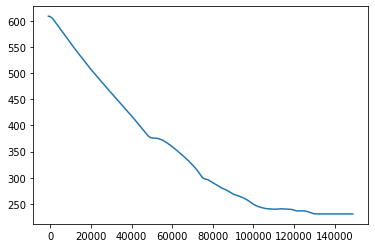

In [13]:
# Plot the depths
plt.figure()
plt.plot(mykdv.x, mykdv.h)


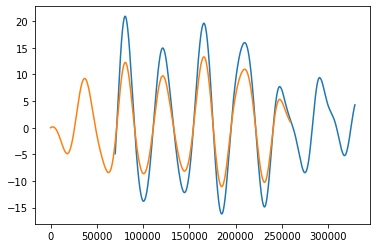

In [14]:
# Testing
timetest = np.arange(0,3*86400,10)
plt.figure()
plt.plot(timetest+twave, F_a0(timetest))
plt.plot(timetest, bcfunc(F_a0, twave, ampfac, timetest, 12*3600) )


In [15]:
mykdv.alpha, mykdv.c, mykdv.dt,mykdv.nonlinear, mykdv.nonhydrostatic, runtime

(array([-0.00996944, -0.00996944, -0.00996944, ...,  0.00626031,
         0.00626031,  0.00626031]),
 array([1.81418501, 1.81418501, 1.81418501, ..., 0.99706057, 0.99706057,
        0.99706057]),
 15.0,
 1,
 1,
 216000.0)

In [16]:
mykdv.print_params()

Parameters (min/max):
 c1 = (0.997061, 1.814185)
 alpha = (-0.009969, 0.006260)
 beta = (2598.321857, 26956.894813)
 Q = (0.412833, 1.000000)



In [17]:
print(mykdv.L_lhs.todense()[0:3,0:8]) 

[[-1.42612053  7.48245741 -7.2783616   2.42612053  0.          0.
   0.          0.        ]
 [-0.20409581 -1.42612053  7.48245741 -7.2783616   2.42612053  0.
   0.          0.        ]
 [-1.21306027  2.22202472  1.         -2.22202472  1.21306027  0.
   0.          0.        ]]


In [18]:
mykdv.beta[0:5]

array([26956.89481325, 26956.89481325, 26956.89481325, 26956.89481325,
       26956.89481325])

In [19]:
# Re-run the solution with the best-fit
# mykdv.nonlinear= 1.
# mykdv.nonhydrostatic= 0.
# mykdv.dt = 10.
# mykdv.spongetime = 120.
# mykdv.spongedist = 20e3

def F_a_test (t):
    omega=np.pi*2/(12*3600.)
    return 1*np.sin(omega*t)

# ds2 = run_vkdv(F_a_test, 0, 1., runtime*0.45, mykdv, infile, verbose=True, ramptime=6*3600.)
ds2 = run_vkdv(F_a0, twave, ampfac, runtime, mykdv, infile, verbose=True)

1 1 1 20000.0
0.0 % complete...
0.0 0.0


<ipython-input-3-6485e0386b8b>:72: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  args = yaml.load(f)


5.0 % complete...
0.16579047287283735 -2.259478083717925
10.0 % complete...
0.17917699951579666 -3.843718077851735
15.0 % complete...
7.193152490372593 7.233166657689097
20.0 % complete...
9.35858423797456 5.605514102528952
25.0 % complete...
9.63148973259233 -4.475464354682155
30.0 % complete...
10.063153028250355 -7.992601331126285
35.0 % complete...
10.43946147391655 7.5946044301794675
40.0 % complete...
12.396469929860588 7.289720856633763
45.0 % complete...
12.749765187512189 -7.45615429621785
50.0 % complete...
13.365301022424422 -3.9798105037045937
55.0 % complete...
13.779224365197148 8.967932557014318
60.0 % complete...
14.950073405901286 3.9296587607990108
65.0 % complete...
16.077708208411206 -6.622244623164963
70.0 % complete...
17.562028408110688 -4.500089097014016
75.0 % complete...
18.1640129831335 11.275132420245324
80.0 % complete...
18.33988278928367 6.155326100780006
85.0 % complete...
15.513177064870286 -10.702399301608892
90.0 % complete...
14.511226366178759 -1.08

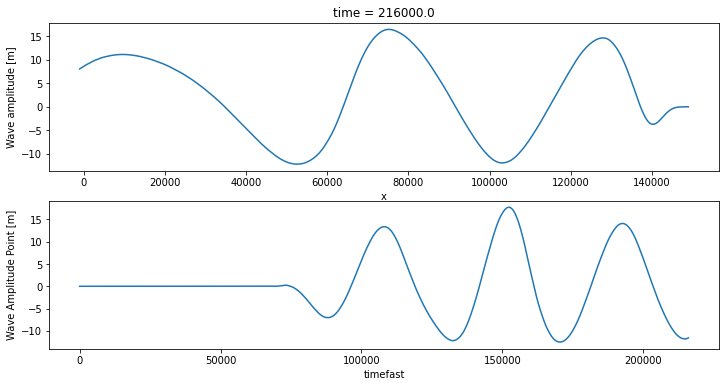

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(211)
ds2.B_t[-1,:].plot()
# plt.ylim(-0.2,0.2)
# ds2.B_t[400,:].plot()

plt.subplot(212)
ds2.B_pt.plot()

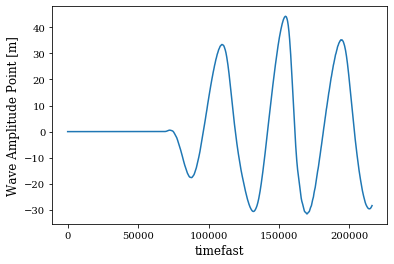